In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101

import torchneuromorphic


/tmp/ipykernel_24042/2154813661.py:45: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torchneuromorphic-0.3.7-py3.8.egg/torchneuromorphic/ntidigits/ntidigits_dataloaders.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torchneuromorphic-0.3.7-py3.8.egg/torchneuromorphic/ntidigits/ntidigits_dataloaders.py:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torchneuromorphic-0.3.7-py3.8.egg/torchneuromorphic/ntidigits/ntidigits_dataloaders.py:99: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torchneuromorphic-0.3.7-py3.8.egg/torchneuromorphic/ntidigits/ntidigits_dataloaders.py:101: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torchneuromorphic-0.3.7-py3.8.egg/torchneuromorphic/ntidigits/ntidigits_dataloaders.py:79:

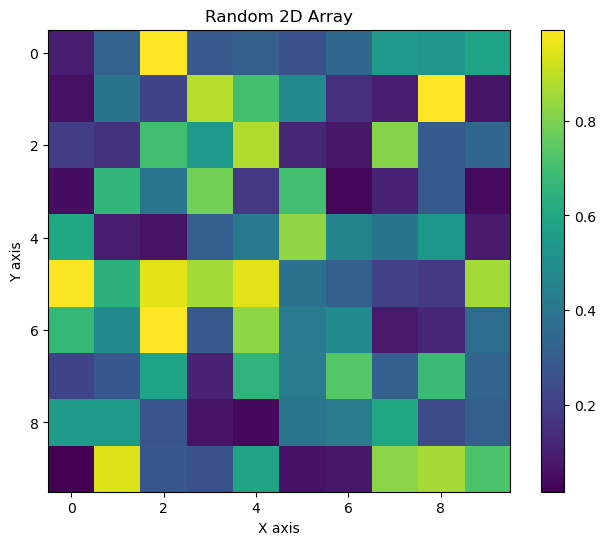

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
 # dvs 데이터 시각화 코드
 ##############################################################################################
            # mapping = {
            #     0: 'Hand Clapping',
            #     1: 'Right Hand Wave',
            #     2: 'Left Hand Wave',
            #     3: 'Right Arm CW',
            #     4: 'Right Arm CCW',
            #     5: 'Left Arm CW',
            #     6: 'Left Arm CCW',
            #     7: 'Arm Roll',
            #     8: 'Air Drums',
            #     9: 'Air Guitar',
            #     10: 'Other'
            # }
def dvs_visualization(inputs, labels, TIME, BATCH):
            
    what_input = random.randint(0, BATCH - 1)
    inputs_for_view = inputs.permute(1, 0, 2, 3, 4)
    for i in range(TIME):
        # 예시 데이터 생성
        data1 = inputs_for_view[what_input][i][0].numpy()  # torch tensor를 numpy 배열로 변환
        data2 = inputs_for_view[what_input][i][1].numpy()  # torch tensor를 numpy 배열로 변환

        # 데이터 플로팅
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1행 2열의 subplot 생성

        # 첫 번째 subplot에 데이터1 플로팅
        im1 = axs[0].imshow(data1, cmap='viridis', interpolation='nearest')
        axs[0].set_title(f'Input 1\nLabel: {labels[what_input]}')  # 라벨값 맵핑하여 제목에 추가
        axs[0].set_xlabel('X axis')
        axs[0].set_ylabel('Y axis')
        axs[0].grid(False)
        fig.colorbar(im1, ax=axs[0])  # Color bar 추가

        # 두 번째 subplot에 데이터2 플로팅
        im2 = axs[1].imshow(data2, cmap='viridis', interpolation='nearest')
        axs[1].set_title(f'Input 2\nLabel: {labels[what_input]}')  # 라벨값 맵핑하여 제목에 추가
        axs[1].set_xlabel('X axis')
        axs[1].set_ylabel('Y axis')
        axs[1].grid(False)
        fig.colorbar(im2, ax=axs[1])  # Color bar 추가

        plt.tight_layout()  # subplot 간 간격 조정
        plt.show()
    sys.exit("종료")

######################################################################################################

In [5]:
def my_snn_system(devices = "0,1,2,3",
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on
                  ):
    # 함수 내 모든 로컬 변수 저장
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0

    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices

    
    torch.manual_seed(my_seed)


    
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME)
    synapse_fc_out_features = CLASS_NUM


    ## parameter number calculator ##########################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ## parameter number calculator ##########################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if pre_trained == False:
        if (convTrue_fcFalse == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                     synapse_fc_trace_const1, synapse_fc_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        else:
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                     synapse_conv_kernel_size, synapse_conv_stride, 
                     synapse_conv_padding, synapse_conv_trace_const1, 
                     synapse_conv_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net)
    else:
        net = torch.load(pre_trained_path)


    net = net.to(device)
    if (net_print == True):
        print(net)
    
    ## param num and memory estimation except BN at MY calculation ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    if (weight_count_print == True):
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f'Layer: {name} | Number of parameters: {param.numel()}')
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ############################################################################################



    ## loss ##########################################
    criterion = nn.CrossEntropyLoss().to(device)
    ## loss ##########################################
    



    ## optimizer, scheduler ##########################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ##########################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()
        running_loss = 0.0

        if (domain_il_epoch>0 and which_data == 'PMNIST'):
            k = epoch // domain_il_epoch
            xtrain=data[k]['train']['x']
            ytrain=data[k]['train']['y']
            xtest =data[k]['test']['x']
            ytest =data[k]['test']['y']

        
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        
        validation_interval2 = validation_interval
        if (validation_interval > len(iterator)):
            validation_interval2 = len(iterator)
            
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train()

            ## data loading #################################
            inputs, labels = data

            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ################################################# 
                

                
#  # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
#  ##############################################################################################
#             dvs_visualization(inputs, labels, TIME, BATCH
# ######################################################################################################


            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # inputs: [Time, Batch, Channel, Height, Width]   
            inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
            # inputs: [Batch, Time, Channel, Height, Width]   
            # print(inputs.size())
            outputs = net(inputs)

            batch = BATCH 
            if labels.size(0) != BATCH: 
                batch = labels.size(0)
            


            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted[0:batch] == labels).sum().item()
            tr_total += total
            tr_correct += correct
            iter_acc = correct / total
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter_acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            

            loss = criterion(outputs[0:batch,:], labels)
            loss.backward()


            ### gradinet verbose ##########################################
            if (gradient_verbose == True):
                if (i % verbose_interval == verbose_interval-1):
                    print('\n\nepoch', epoch, 'iter', i)
                    for name, param in net.named_parameters():
                        if param.requires_grad:
                            print('\n\n\n\n' , name, param.grad)
            ################################################################
            
            optimizer.step()

            running_loss += loss.item()
            # print("Epoch: {}, Iter: {}, Loss: {}".format(epoch + 1, i + 1, running_loss / 100))

            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##############################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval()
                    for data in test_loader:
                        ## data loading #################################
                        inputs, labels = data

                        
                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ################################################# 

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs.permute(1, 0, 2, 3, 4))
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        batch = BATCH 
                        if labels.size(0) != BATCH: 
                            batch = labels.size(0)
                        correct += (predicted[0:batch] == labels).sum().item()
                        val_loss = criterion(outputs[0:batch,:], labels)

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    torch.save(net.state_dict(), "net_save/save_now_net_weights.pth")
                    torch.save(net, "net_save/save_now_net.pth")
                    torch.save(net.module.state_dict(), "net_save/save_now_net_weights2.pth")
                    torch.save(net.module, "net_save/save_now_net2.pth")
            ################################################################
            iterator.set_description(f"iter_acc: {iter_acc_string}, iter_loss: {loss}, val_acc: {100 * val_acc_now:.2f}%")  

            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            iter_acc_file_name = f'result_save/{base_name}_iter_acc_array.npy'
            tr_acc_file_name = f'result_save/{base_name}_tr_acc_array.npy'
            val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
            hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

            hyperparameters['current epoch'] = epoch

            # 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기)
            # np.save(iter_acc_file_name, iter_acc_array)
            # np.save(val_acc_file_name, val_acc_now_array)
            # with open(hyperparameters_file_name, 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)

            np.save('result_save/iter_acc_array.npy', iter_acc_array)
            np.save('result_save/tr_acc_array.npy', tr_acc_array)
            np.save('result_save/val_acc_now_array.npy', val_acc_now_array)
            with open('result_save/hyperparameters.json', 'w') as f:
                json.dump(hyperparameters, f, indent=4)
            
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        
        epoch_time_end = time.time()
        epoch_time = epoch_time_end - epoch_start_time  # 실행 시간 계산
        
        print(f"epoch_time: {epoch_time} seconds")
        print('\n')


In [6]:
### my_snn control board ########################
decay = 0.25 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

my_snn_system(  devices = "1",
                my_seed = 42,
                TIME = 8 , # dvscifar 10 # ottt 6 or 10 # nda 10
                BATCH = 5, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 128, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'DVS_GESTURE',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = True, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 0.5,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 10000.0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False
                weight_count_print = False, # True # False
                pre_trained_path = "net_save/save_now_net.pth",
                learning_rate = 0.001, # default 0.001  # ottt 0.1  # nda 0.001
                epoch_num = 200,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함
                tdBN_on = True,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'rough_rectangle', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'Adam', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling이 낫다.

# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


The directory [/data2/gesture/frames_number_8_split_by_number] already exists.
The directory [/data2/gesture/frames_number_8_split_by_number] already exists.
DataParallel(
  (module): MY_SNN_FC(
    (layers): Sequential(
      (0): SYNAPSE_FC()
      (1): tdBatchNorm_FC(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LIF_layer()
      (3): SYNAPSE_FC()
    )
  )
)
My Num of PARAMS: 2,097,866, system's param_num : 2,097,994
Memory: 8.00MiB at 32-bit
EPOCH 0


train:   0%|          | 0/216 [00:00<?, ?it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 8, 7, 5, 5])


iter_acc: 0-6/216 iter_acc: 0.00%, lr=['1.953125e-05'], iter_loss: 2.3497512340545654, val_acc: 0.00%:   2%|▏         | 5/216 [00:01<00:36,  5.77it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 2, 6, 8, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 7, 6, 2, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 1, 1, 1, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 9, 9, 9, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 5, 8, 6, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 9, 7, 5, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 6, 9, 3, 8])


iter_acc: 0-11/216 iter_acc: 0.00%, lr=['1.953125e-05'], iter_loss: 2.127671003341675, val_acc: 0.00%:   5%|▌         | 11/216 [00:01<00:16, 12.32it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 0, 7, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 4, 7, 9, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 8, 3, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 9, 8, 9, 1])


iter_acc: 0-14/216 iter_acc: 20.00%, lr=['1.953125e-05'], iter_loss: 2.4487569332122803, val_acc: 0.00%:   6%|▋         | 14/216 [00:01<00:15, 13.01it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 0, 4, 9, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 9, 3, 9, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 2, 3, 0, 2])


iter_acc: 0-19/216 iter_acc: 40.00%, lr=['1.953125e-05'], iter_loss: 1.9016048908233643, val_acc: 0.00%:   8%|▊         | 17/216 [00:01<00:13, 14.87it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 5, 8, 1, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 8, 9, 4, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 6, 8, 6, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 0, 0, 8, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 8, 3, 2, 6])


iter_acc: 0-24/216 iter_acc: 20.00%, lr=['1.953125e-05'], iter_loss: 1.908532738685608, val_acc: 0.00%:  11%|█         | 23/216 [00:02<00:10, 18.38it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 8, 3, 7, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 1, 0, 0, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 2, 5, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 7, 5, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 9, 5, 5, 1])


iter_acc: 0-28/216 iter_acc: 0.00%, lr=['1.953125e-05'], iter_loss: 2.261087656021118, val_acc: 0.00%:  13%|█▎        | 29/216 [00:02<00:09, 18.90it/s]  

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 8, 6, 8, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 6, 8, 8, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 7, 4, 6, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 8, 8, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 6, 8, 9, 1])


iter_acc: 0-33/216 iter_acc: 0.00%, lr=['1.953125e-05'], iter_loss: 2.1242194175720215, val_acc: 0.00%:  15%|█▍        | 32/216 [00:02<00:09, 19.08it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 7, 4, 1, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 1, 2, 3, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 8, 3, 9, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 4, 9, 0, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 2, 8, 9, 6])


iter_acc: 0-38/216 iter_acc: 40.00%, lr=['1.953125e-05'], iter_loss: 1.7921291589736938, val_acc: 0.00%:  18%|█▊        | 38/216 [00:02<00:09, 19.44it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 5, 2, 5, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 6, 6, 7, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 8, 2, 5, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 1, 1, 1, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])


iter_acc: 0-42/216 iter_acc: 80.00%, lr=['1.953125e-05'], iter_loss: 1.2253055572509766, val_acc: 0.00%:  19%|█▉        | 41/216 [00:02<00:08, 20.91it/s]

tensor([8, 1, 4, 7, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 9, 8, 2, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 7, 6, 1, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 7, 5, 8, 8])


iter_acc: 0-46/216 iter_acc: 20.00%, lr=['1.953125e-05'], iter_loss: 1.7527719736099243, val_acc: 0.00%:  21%|██▏       | 46/216 [00:03<00:09, 18.47it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 6, 1, 5, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 8, 1, 9, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 9, 1, 0, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 4, 9, 8, 5])


iter_acc: 0-50/216 iter_acc: 20.00%, lr=['1.953125e-05'], iter_loss: 2.1450579166412354, val_acc: 0.00%:  23%|██▎       | 49/216 [00:03<00:08, 20.50it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 0, 2, 2, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 6, 5, 1, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 6, 8, 4, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 8, 2, 6, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 9, 5, 9, 6])


iter_acc: 0-56/216 iter_acc: 60.00%, lr=['1.953125e-05'], iter_loss: 1.667365312576294, val_acc: 0.00%:  25%|██▌       | 55/216 [00:03<00:07, 21.14it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 3, 6, 7, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 6, 1, 9, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 1, 4, 8, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 4, 6, 6, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 1, 2, 8, 5])


iter_acc: 0-60/216 iter_acc: 40.00%, lr=['1.953125e-05'], iter_loss: 1.8264278173446655, val_acc: 0.00%:  28%|██▊       | 61/216 [00:03<00:07, 20.35it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 4, 5, 3, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 1, 2, 8, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 4, 9, 9, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 2, 8, 9, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 4, 7, 0, 7])


iter_acc: 0-66/216 iter_acc: 60.00%, lr=['1.953125e-05'], iter_loss: 1.813829779624939, val_acc: 0.00%:  31%|███       | 67/216 [00:04<00:06, 21.59it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 3, 2, 1, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 1, 2, 3, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 8, 2, 6, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 4, 3, 1, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 8, 8, 2, 5])


iter_acc: 0-70/216 iter_acc: 40.00%, lr=['1.953125e-05'], iter_loss: 1.638763427734375, val_acc: 0.00%:  32%|███▏      | 70/216 [00:04<00:07, 20.54it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 7, 8, 6, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 7, 4, 8, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 8, 3, 8, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 5, 4, 8, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 8, 1, 7, 3])


iter_acc: 0-76/216 iter_acc: 20.00%, lr=['1.953125e-05'], iter_loss: 1.8958542346954346, val_acc: 0.00%:  35%|███▌      | 76/216 [00:04<00:06, 21.11it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 2, 1, 6, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 2, 7, 0, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 8, 5, 7, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 1, 0, 6, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 2, 4, 9, 8])


iter_acc: 0-80/216 iter_acc: 20.00%, lr=['1.953125e-05'], iter_loss: 2.319192886352539, val_acc: 0.00%:  37%|███▋      | 79/216 [00:04<00:06, 22.15it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 3, 0, 2, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 9, 8, 2, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 0, 8, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 2, 8, 2, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 0, 8, 8, 2])


iter_acc: 0-86/216 iter_acc: 20.00%, lr=['1.953125e-05'], iter_loss: 1.7698789834976196, val_acc: 0.00%:  39%|███▉      | 85/216 [00:05<00:05, 22.17it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 6, 2, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 9, 8, 8, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 5, 4, 5, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 5, 7, 1, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 1, 9, 1, 4])


iter_acc: 0-90/216 iter_acc: 60.00%, lr=['1.953125e-05'], iter_loss: 1.4691894054412842, val_acc: 0.00%:  42%|████▏     | 91/216 [00:05<00:05, 21.45it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 2, 0, 7, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 4, 8, 6, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 4, 3, 1, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 4, 0, 7, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 5, 9, 0, 8])


iter_acc: 0-96/216 iter_acc: 20.00%, lr=['1.953125e-05'], iter_loss: 1.6472530364990234, val_acc: 0.00%:  44%|████▎     | 94/216 [00:05<00:05, 22.81it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 2, 4, 6, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 5, 2, 0, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 0, 8, 8, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 2, 8, 3, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 4, 4, 9, 5])


iter_acc: 0-101/216 iter_acc: 40.00%, lr=['1.953125e-05'], iter_loss: 1.5797481536865234, val_acc: 0.00%:  46%|████▋     | 100/216 [00:05<00:05, 22.93it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 2, 5, 7, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 0, 7, 8, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 7, 5, 0, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 8, 7, 9, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 4, 4, 4, 3])


iter_acc: 0-106/216 iter_acc: 20.00%, lr=['1.953125e-05'], iter_loss: 2.287881374359131, val_acc: 0.00%:  49%|████▉     | 106/216 [00:05<00:04, 22.67it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 4, 4, 6, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 2, 8, 0, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 7, 6, 4, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 4, 0, 9, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 2, 2, 2, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])


iter_acc: 0-111/216 iter_acc: 80.00%, lr=['1.953125e-05'], iter_loss: 1.3990280628204346, val_acc: 0.00%:  52%|█████▏    | 112/216 [00:06<00:04, 24.04it/s]

tensor([8, 3, 5, 1, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 7, 0, 2, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 6, 3, 9, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 5, 8, 3, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 9, 0, 7, 8])


iter_acc: 0-115/216 iter_acc: 40.00%, lr=['1.953125e-05'], iter_loss: 1.2213077545166016, val_acc: 0.00%:  53%|█████▎    | 115/216 [00:06<00:04, 22.80it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 7, 7, 7, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 1, 5, 5, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 4, 7, 0, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 3, 7, 5, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 9, 4, 8, 0])


iter_acc: 0-121/216 iter_acc: 60.00%, lr=['1.953125e-05'], iter_loss: 1.4156360626220703, val_acc: 0.00%:  56%|█████▌    | 121/216 [00:06<00:04, 23.05it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 8, 2, 7, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 5, 6, 0, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 6, 0, 4, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 6, 8, 0, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 4, 9, 8, 6])


iter_acc: 0-125/216 iter_acc: 40.00%, lr=['1.953125e-05'], iter_loss: 1.5244239568710327, val_acc: 0.00%:  57%|█████▋    | 124/216 [00:06<00:03, 23.95it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 5, 8, 3, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 3, 3, 8, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 4, 8, 3, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 4, 7, 3, 2])


iter_acc: 0-129/216 iter_acc: 40.00%, lr=['1.953125e-05'], iter_loss: 1.287624716758728, val_acc: 0.00%:  60%|██████    | 130/216 [00:07<00:04, 20.60it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 4, 8, 2, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 3, 7, 9, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 5, 7, 6, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 9, 1, 4, 1])


iter_acc: 0-134/216 iter_acc: 60.00%, lr=['1.953125e-05'], iter_loss: 1.182804822921753, val_acc: 0.00%:  62%|██████▏   | 133/216 [00:07<00:04, 19.29it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 9, 5, 8, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 2, 1, 3, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 9, 9, 9, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 0, 0, 8, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 7, 8, 9, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 8, 7, 7, 0])


iter_acc: 0-139/216 iter_acc: 20.00%, lr=['1.953125e-05'], iter_loss: 1.6266530752182007, val_acc: 0.00%:  64%|██████▍   | 139/216 [00:07<00:04, 19.23it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 8, 7, 4, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 3, 3, 6, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 4, 8, 5, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 1, 0, 6, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 1, 5, 5, 7])


iter_acc: 0-145/216 iter_acc: 40.00%, lr=['1.953125e-05'], iter_loss: 1.493345856666565, val_acc: 0.00%:  67%|██████▋   | 145/216 [00:07<00:03, 20.72it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 8, 2, 2, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 1, 0, 4, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 4, 1, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 2, 4, 8, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 5, 5, 1, 6])


iter_acc: 0-150/216 iter_acc: 60.00%, lr=['1.953125e-05'], iter_loss: 1.6345479488372803, val_acc: 0.00%:  70%|██████▉   | 151/216 [00:08<00:03, 21.53it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 5, 4, 0, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 9, 1, 0, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 6, 6, 1, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 7, 3, 1, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 0, 8, 2, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 4, 0, 1, 3])


iter_acc: 0-155/216 iter_acc: 20.00%, lr=['1.953125e-05'], iter_loss: 1.5376237630844116, val_acc: 0.00%:  71%|███████▏  | 154/216 [00:08<00:02, 22.36it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 6, 3, 1, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 2, 8, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 7, 0, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 5, 3, 0, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 4, 3, 8, 0])


iter_acc: 0-161/216 iter_acc: 40.00%, lr=['1.953125e-05'], iter_loss: 1.430383324623108, val_acc: 0.00%:  74%|███████▍  | 160/216 [00:08<00:02, 22.25it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 2, 5, 1, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 1, 0, 0, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 1, 0, 8, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 7, 4, 7, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 6, 8, 8, 0])


iter_acc: 0-165/216 iter_acc: 0.00%, lr=['1.953125e-05'], iter_loss: 2.0273501873016357, val_acc: 0.00%:  77%|███████▋  | 166/216 [00:08<00:02, 22.07it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 8, 0, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 2, 2, 8, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 3, 2, 6, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 3, 9, 0, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 6, 8, 9, 9])


iter_acc: 0-171/216 iter_acc: 100.00%, lr=['1.953125e-05'], iter_loss: 1.1200945377349854, val_acc: 0.00%:  80%|███████▉  | 172/216 [00:08<00:01, 22.61it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 2, 3, 6, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 6, 4, 8, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 9, 4, 5, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 1, 7, 0, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 0, 8, 7, 5])


iter_acc: 0-175/216 iter_acc: 80.00%, lr=['1.953125e-05'], iter_loss: 1.167038083076477, val_acc: 0.00%:  81%|████████  | 175/216 [00:09<00:02, 20.08it/s]  

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 8, 8, 3, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 8, 9, 9, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 4, 6, 2, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 7, 8, 9, 3])


iter_acc: 0-179/216 iter_acc: 40.00%, lr=['1.953125e-05'], iter_loss: 1.560564398765564, val_acc: 0.00%:  82%|████████▏ | 178/216 [00:09<00:01, 21.43it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 3, 6, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 8, 9, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 0, 1, 4, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 8, 9, 3, 4])


iter_acc: 0-184/216 iter_acc: 40.00%, lr=['1.953125e-05'], iter_loss: 1.880303978919983, val_acc: 0.00%:  85%|████████▌ | 184/216 [00:09<00:01, 21.62it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 9, 7, 8, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 4, 1, 6, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 5, 7, 6, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 6, 8, 9, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 4, 7, 4, 5])


iter_acc: 0-189/216 iter_acc: 80.00%, lr=['1.953125e-05'], iter_loss: 1.1933794021606445, val_acc: 0.00%:  87%|████████▋ | 187/216 [00:09<00:01, 20.32it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 2, 5, 4, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 8, 9, 1, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 8, 8, 2, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 1, 7, 8, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 9, 7, 8, 8])


iter_acc: 0-194/216 iter_acc: 60.00%, lr=['1.953125e-05'], iter_loss: 1.2565233707427979, val_acc: 0.00%:  89%|████████▉ | 193/216 [00:10<00:01, 21.38it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 8, 0, 0, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 8, 2, 7, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 6, 2, 5, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 2, 1, 7, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 8, 9, 8, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 8, 1, 3, 8])


iter_acc: 0-200/216 iter_acc: 60.00%, lr=['1.953125e-05'], iter_loss: 1.5562999248504639, val_acc: 0.00%:  92%|█████████▏| 199/216 [00:10<00:00, 21.66it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 5, 1, 5, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 0, 6, 2, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 8, 9, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 6, 7, 7, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 9, 7, 9, 0])


iter_acc: 0-204/216 iter_acc: 40.00%, lr=['1.953125e-05'], iter_loss: 1.2940038442611694, val_acc: 0.00%:  95%|█████████▍| 205/216 [00:10<00:00, 21.26it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 9, 5, 5, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 5, 2, 8, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 6, 8, 2, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 2, 1, 8, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 7, 2, 4, 8])


iter_acc: 0-209/216 iter_acc: 20.00%, lr=['1.953125e-05'], iter_loss: 2.144766330718994, val_acc: 0.00%:  96%|█████████▋| 208/216 [00:10<00:00, 22.78it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 3, 4, 8, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 4, 6, 3, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 2, 3, 8, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 4, 1, 5, 5])


iter_acc: 0-213/216 iter_acc: 80.00%, lr=['1.953125e-05'], iter_loss: 1.0100432634353638, val_acc: 0.00%:  99%|█████████▉| 214/216 [00:10<00:00, 22.14it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 4, 5, 8, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 5, 4, 0, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 1, 0, 5, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 1, 9, 7, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 9, 8, 2, 3])


iter_acc: 0-214/216 iter_acc: 60.00%, lr=['1.953125e-05'], iter_loss: 1.3545494079589844, val_acc: 0.00%:  99%|█████████▉| 214/216 [00:11<00:00, 22.14it/s]

inputs torch.Size([3, 8, 2, 128, 128]) 
labels torch.Size([3])
tensor([2, 8, 8])


iter_acc: 0-215/216 iter_acc: 0.00%, lr=['1.953125e-05'], iter_loss: 2.1618611812591553, val_acc: 55.30%: 100%|██████████| 216/216 [00:14<00:00, 15.35it/s]

epoch_time: 14.214603185653687 seconds


EPOCH 1



iter_acc: 1-4/216 iter_acc: 100.00%, lr=['1.9530045239078716e-05'], iter_loss: 0.7256481051445007, val_acc: 55.30%:   2%|▏         | 4/216 [00:00<00:12, 16.36it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 9, 6, 3, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 2, 5, 4, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 5, 2, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 7, 0, 6, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 6, 8, 7, 8])


iter_acc: 1-9/216 iter_acc: 60.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.4259405136108398, val_acc: 55.30%:   5%|▍         | 10/216 [00:00<00:09, 21.24it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 5, 5, 2, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 4, 8, 8, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 5, 0, 9, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 3, 8, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 0, 8, 8, 2])


iter_acc: 1-14/216 iter_acc: 80.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.2863489389419556, val_acc: 55.30%:   6%|▌         | 13/216 [00:00<00:10, 19.86it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 9, 3, 1, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 6, 1, 0, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 0, 9, 0, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 5, 6, 4, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 2, 3, 8, 3])


iter_acc: 1-19/216 iter_acc: 60.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.3584269285202026, val_acc: 55.30%:   9%|▉         | 19/216 [00:00<00:09, 21.19it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 8, 0, 9, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 2, 5, 9, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 0, 5, 2, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 2, 0, 1, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 4, 7, 0, 5])


iter_acc: 1-24/216 iter_acc: 40.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.871655821800232, val_acc: 55.30%:  12%|█▏        | 25/216 [00:01<00:08, 21.98it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 2, 1, 7, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 7, 4, 0, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 0, 5, 2, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 1, 1, 7, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 7, 7, 9, 2])


iter_acc: 1-29/216 iter_acc: 60.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.260513186454773, val_acc: 55.30%:  13%|█▎        | 28/216 [00:01<00:08, 21.66it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 2, 1, 1, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 1, 4, 7, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 8, 2, 0, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 5, 4, 8, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 7, 5, 5, 9])


iter_acc: 1-34/216 iter_acc: 40.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.1403064727783203, val_acc: 55.30%:  16%|█▌        | 34/216 [00:01<00:08, 22.24it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 3, 8, 9, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 7, 3, 8, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 8, 0, 8, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 0, 6, 9, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 9, 7, 8, 4])


iter_acc: 1-38/216 iter_acc: 60.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.0880255699157715, val_acc: 55.30%:  17%|█▋        | 37/216 [00:01<00:08, 21.50it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 6, 1, 9, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 7, 1, 2, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 5, 3, 1, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 1, 8, 5, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])


iter_acc: 1-43/216 iter_acc: 100.00%, lr=['1.9530045239078716e-05'], iter_loss: 0.887089729309082, val_acc: 55.30%:  20%|█▉        | 43/216 [00:02<00:07, 21.69it/s]

tensor([3, 7, 5, 3, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 8, 1, 9, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 2, 2, 8, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 3, 7, 6, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 1, 3, 8])


iter_acc: 1-47/216 iter_acc: 40.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.9009888172149658, val_acc: 55.30%:  21%|██▏       | 46/216 [00:02<00:07, 21.66it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 5, 0, 7, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 3, 4, 1, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 9, 8, 6, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 6, 8, 2, 2])


iter_acc: 1-51/216 iter_acc: 40.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.7537734508514404, val_acc: 55.30%:  24%|██▍       | 52/216 [00:02<00:07, 21.29it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 1, 3, 5, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 6, 2, 9, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 0, 9, 8, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 8, 2, 8, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 8, 1, 1, 5])


iter_acc: 1-57/216 iter_acc: 60.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.2688753604888916, val_acc: 55.30%:  25%|██▌       | 55/216 [00:02<00:07, 20.74it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 8, 3, 6, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 3, 6, 6, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 1, 7, 8, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 9, 4, 1, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 1, 3, 1, 6])


iter_acc: 1-62/216 iter_acc: 80.00%, lr=['1.9530045239078716e-05'], iter_loss: 0.8800538182258606, val_acc: 55.30%:  28%|██▊       | 61/216 [00:02<00:06, 22.47it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 8, 2, 4, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 6, 6, 8, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 8, 5, 5, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 0, 4, 5, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 9, 1, 7, 1])


iter_acc: 1-67/216 iter_acc: 80.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.122899055480957, val_acc: 55.30%:  31%|███       | 67/216 [00:03<00:06, 23.10it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 6, 1, 5, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 3, 3, 8, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 0, 8, 6, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 5, 0, 4, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 3, 1, 8, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 0, 2, 6, 4])


iter_acc: 1-73/216 iter_acc: 100.00%, lr=['1.9530045239078716e-05'], iter_loss: 0.8271986246109009, val_acc: 55.30%:  34%|███▍      | 73/216 [00:03<00:06, 22.33it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 7, 2, 0, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 8, 4, 6, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 9, 4, 5, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 8, 9, 4, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 4, 1, 5, 7])


iter_acc: 1-77/216 iter_acc: 60.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.011838674545288, val_acc: 55.30%:  35%|███▌      | 76/216 [00:03<00:05, 23.49it/s]  

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 6, 8, 8, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 7, 2, 9, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 7, 3, 2, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 2, 7, 1, 8])


iter_acc: 1-81/216 iter_acc: 20.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.6897075176239014, val_acc: 55.30%:  38%|███▊      | 82/216 [00:03<00:06, 21.72it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 3, 8, 2, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 1, 8, 9, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 9, 0, 1, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 8, 8, 8, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 5, 9, 5, 9])


iter_acc: 1-87/216 iter_acc: 60.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.323571801185608, val_acc: 55.30%:  39%|███▉      | 85/216 [00:04<00:06, 20.98it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 6, 8, 2, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 8, 1, 1, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 9, 1, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 7, 2, 1, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 5, 9, 4, 8])


iter_acc: 1-91/216 iter_acc: 60.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.0231997966766357, val_acc: 55.30%:  42%|████▏     | 91/216 [00:04<00:05, 21.23it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 9, 8, 1, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 1, 4, 3, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 8, 8, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 4, 6, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 2, 6, 1, 6])


iter_acc: 1-96/216 iter_acc: 80.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.1989963054656982, val_acc: 55.30%:  45%|████▍     | 97/216 [00:04<00:05, 20.94it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 9, 5, 5, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 7, 5, 6, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 0, 1, 8, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 2, 0, 3, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 9, 8, 3, 3])


iter_acc: 1-102/216 iter_acc: 100.00%, lr=['1.9530045239078716e-05'], iter_loss: 0.8184263110160828, val_acc: 55.30%:  46%|████▋     | 100/216 [00:04<00:05, 20.89it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 3, 4, 7, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 5, 5, 4, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 1, 8, 1, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 6, 8, 6, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 8, 9, 1, 3])


iter_acc: 1-107/216 iter_acc: 20.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.8599538803100586, val_acc: 55.30%:  49%|████▉     | 106/216 [00:05<00:05, 21.85it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 7, 2, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 4, 9, 3, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 1, 7, 9, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 3, 0, 1, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 1, 4, 4, 4])


iter_acc: 1-111/216 iter_acc: 80.00%, lr=['1.9530045239078716e-05'], iter_loss: 0.8482699394226074, val_acc: 55.30%:  52%|█████▏    | 112/216 [00:05<00:04, 22.80it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 8, 5, 8, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 2, 2, 8, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 4, 8, 8, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 5, 5, 3, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 5, 1, 0, 4])


iter_acc: 1-117/216 iter_acc: 60.00%, lr=['1.9530045239078716e-05'], iter_loss: 0.990892231464386, val_acc: 55.30%:  53%|█████▎    | 115/216 [00:05<00:04, 21.12it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 7, 9, 5, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 7, 2, 6, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 4, 2, 0, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 2, 6, 4, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 3, 3, 4, 4])


iter_acc: 1-122/216 iter_acc: 60.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.162199854850769, val_acc: 55.30%:  56%|█████▌    | 121/216 [00:05<00:04, 21.79it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 7, 6, 3, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 9, 3, 1, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 2, 8, 2, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 9, 2, 8, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 0, 2, 6, 4])


iter_acc: 1-126/216 iter_acc: 20.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.641164779663086, val_acc: 55.30%:  59%|█████▉    | 127/216 [00:05<00:04, 21.65it/s]  

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 5, 8, 8, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 9, 4, 0, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 9, 8, 8, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 4, 8, 4, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 6, 4, 0, 7])


iter_acc: 1-132/216 iter_acc: 80.00%, lr=['1.9530045239078716e-05'], iter_loss: 0.9557949304580688, val_acc: 55.30%:  62%|██████▏   | 133/216 [00:06<00:03, 23.24it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 2, 7, 5, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 8, 9, 9, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 8, 6, 2, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 7, 5, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 9, 8, 7, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 0, 7, 2, 2])


iter_acc: 1-137/216 iter_acc: 60.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.081247329711914, val_acc: 55.30%:  63%|██████▎   | 136/216 [00:06<00:03, 22.82it/s]  

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 9, 1, 8, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 1, 0, 6, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 2, 5, 3, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 8, 3, 4, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 3, 4, 4, 2])


iter_acc: 1-142/216 iter_acc: 80.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.810288429260254, val_acc: 55.30%:  66%|██████▌   | 142/216 [00:06<00:03, 22.58it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 8, 5, 2, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 3, 9, 5, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 2, 6, 6, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 9, 8, 9, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 9, 9, 4, 8])


iter_acc: 1-147/216 iter_acc: 40.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.1988747119903564, val_acc: 55.30%:  69%|██████▊   | 148/216 [00:06<00:03, 22.14it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 5, 6, 3, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 8, 4, 9, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 6, 7, 9, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 1, 8, 5, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 7, 0, 8, 5])


iter_acc: 1-152/216 iter_acc: 20.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.7621389627456665, val_acc: 55.30%:  70%|██████▉   | 151/216 [00:07<00:03, 21.13it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 8, 4, 7, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 0, 9, 9, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 6, 7, 3, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 9, 8, 0, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 9, 1, 8, 6])


iter_acc: 1-158/216 iter_acc: 80.00%, lr=['1.9530045239078716e-05'], iter_loss: 0.9847031831741333, val_acc: 55.30%:  73%|███████▎  | 157/216 [00:07<00:02, 21.67it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 6, 7, 0, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 7, 9, 3, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 0, 9, 1, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 3, 8, 8, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 8, 5, 7, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 8, 9, 6, 3])


iter_acc: 1-164/216 iter_acc: 20.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.6640903949737549, val_acc: 55.30%:  75%|███████▌  | 163/216 [00:07<00:02, 21.62it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 7, 0, 3, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 2, 3, 8, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 8, 6, 2, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 7, 1, 2, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 0, 3, 6, 3])


iter_acc: 1-168/216 iter_acc: 80.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.0007036924362183, val_acc: 55.30%:  78%|███████▊  | 169/216 [00:07<00:02, 20.51it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 8, 9, 8, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 2, 3, 6, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 9, 9, 8, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 6, 1, 4, 4])


iter_acc: 1-173/216 iter_acc: 20.00%, lr=['1.9530045239078716e-05'], iter_loss: 2.119220733642578, val_acc: 55.30%:  80%|███████▉  | 172/216 [00:08<00:01, 22.34it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 6, 8, 5, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 0, 2, 1, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 8, 7, 7, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 2, 9, 4, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 2, 9, 2, 4])


iter_acc: 1-179/216 iter_acc: 80.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.0436794757843018, val_acc: 55.30%:  83%|████████▎ | 179/216 [00:08<00:01, 23.22it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 8, 2, 2, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 8, 6, 5, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 6, 2, 2, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 2, 8, 7, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 3, 3, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 9, 8, 8, 6])


iter_acc: 1-183/216 iter_acc: 40.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.462836503982544, val_acc: 55.30%:  84%|████████▍ | 182/216 [00:08<00:01, 23.35it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 5, 4, 0, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 9, 9, 6, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 7, 5, 2, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 7, 7, 7, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 9, 2, 9, 7])


iter_acc: 1-189/216 iter_acc: 80.00%, lr=['1.9530045239078716e-05'], iter_loss: 0.91227787733078, val_acc: 55.30%:  87%|████████▋ | 188/216 [00:08<00:01, 22.53it/s]  

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 1, 4, 8, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 5, 6, 4, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 8, 8, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 0, 8, 0, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 7, 8, 4, 9])


iter_acc: 1-194/216 iter_acc: 20.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.4554179906845093, val_acc: 55.30%:  90%|████████▉ | 194/216 [00:08<00:00, 23.08it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 4, 0, 5, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 5, 7, 0, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 4, 9, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 4, 7, 9, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 7, 9, 0, 5])


iter_acc: 1-198/216 iter_acc: 60.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.16045343875885, val_acc: 55.30%:  91%|█████████ | 197/216 [00:09<00:00, 22.13it/s]  

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 5, 7, 4, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 3, 3, 4, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 8, 0, 8, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 0, 5, 6, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 8, 5, 8, 8])


iter_acc: 1-205/216 iter_acc: 80.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.2419776916503906, val_acc: 55.30%:  94%|█████████▍| 203/216 [00:09<00:00, 22.42it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 3, 4, 8, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 5, 8, 8, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 0, 6, 8, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 8, 0, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 6, 0, 7, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 2, 3, 3, 8])


iter_acc: 1-210/216 iter_acc: 60.00%, lr=['1.9530045239078716e-05'], iter_loss: 1.4383656978607178, val_acc: 55.30%:  97%|█████████▋| 210/216 [00:09<00:00, 23.47it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 5, 8, 0, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 9, 6, 4, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 6, 7, 1, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 8, 0, 7, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 0, 4, 0, 8])


iter_acc: 1-214/216 iter_acc: 100.00%, lr=['1.9530045239078716e-05'], iter_loss: 0.8409996032714844, val_acc: 55.30%:  99%|█████████▊| 213/216 [00:09<00:00, 22.53it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 8, 8, 5, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 4, 8, 8, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 8, 9, 8, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 3, 8, 8, 7])
inputs torch.Size([3, 8, 2, 128, 128]) 
labels torch.Size([3])
tensor([5, 5, 1])


iter_acc: 1-215/216 iter_acc: 66.67%, lr=['1.9530045239078716e-05'], iter_loss: 1.6768327951431274, val_acc: 60.61%: 100%|██████████| 216/216 [00:12<00:00, 16.75it/s] 

epoch_time: 13.049832582473755 seconds


EPOCH 2



iter_acc: 2-4/216 iter_acc: 40.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.0916435718536377, val_acc: 60.61%:   2%|▏         | 4/216 [00:00<00:12, 17.17it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 8, 6, 9, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 2, 8, 6, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 6, 8, 5, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 3, 4, 4, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 9, 1, 9, 6])


iter_acc: 2-9/216 iter_acc: 40.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.2087500095367432, val_acc: 60.61%:   3%|▎         | 7/216 [00:00<00:10, 20.70it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 1, 8, 8, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 5, 4, 5, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 0, 8, 3, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 2, 3, 9, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 7, 8, 2, 9])


iter_acc: 2-13/216 iter_acc: 80.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.074236273765564, val_acc: 60.61%:   6%|▌         | 13/216 [00:00<00:09, 22.20it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 2, 6, 3, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 9, 6, 4, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 5, 2, 1, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 5, 8, 2, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 6, 1, 0, 2])


iter_acc: 2-19/216 iter_acc: 0.00%, lr=['1.9526431253571596e-05'], iter_loss: 2.3094892501831055, val_acc: 60.61%:   9%|▉         | 19/216 [00:00<00:08, 21.99it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 0, 6, 4, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 2, 0, 5, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 7, 3, 5, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 1, 9, 1, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 4, 5, 4, 4])


iter_acc: 2-23/216 iter_acc: 100.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.0516072511672974, val_acc: 60.61%:  10%|█         | 22/216 [00:01<00:09, 21.05it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 0, 1, 2, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 3, 5, 1, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 6, 5, 8, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 7, 8, 6, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 8, 4, 2, 7])


iter_acc: 2-28/216 iter_acc: 80.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.1451152563095093, val_acc: 60.61%:  13%|█▎        | 28/216 [00:01<00:08, 21.22it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 8, 1, 4, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 1, 0, 1, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 2, 8, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 3, 5, 3, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 9, 7, 4, 1])


iter_acc: 2-33/216 iter_acc: 60.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.217402458190918, val_acc: 60.61%:  16%|█▌        | 34/216 [00:01<00:08, 21.12it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 3, 8, 0, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 5, 6, 9, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 9, 3, 2, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 3, 7, 7, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 5, 0, 8, 1])


iter_acc: 2-38/216 iter_acc: 60.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.0333220958709717, val_acc: 60.61%:  17%|█▋        | 37/216 [00:01<00:08, 21.83it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 0, 9, 2, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 0, 0, 8, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 9, 7, 7, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 6, 3, 3, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 6, 6, 9, 2])


iter_acc: 2-43/216 iter_acc: 60.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.1773254871368408, val_acc: 60.61%:  20%|█▉        | 43/216 [00:02<00:08, 20.02it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 2, 3, 7, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 2, 9, 0, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 8, 9, 1, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 8, 3, 2, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 3, 5, 1, 5])


iter_acc: 2-48/216 iter_acc: 60.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.6553077697753906, val_acc: 60.61%:  23%|██▎       | 49/216 [00:02<00:08, 20.58it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 4, 8, 8, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 5, 7, 6, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 3, 1, 9, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 9, 8, 5, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 3, 8, 4, 6])


iter_acc: 2-53/216 iter_acc: 80.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.1801544427871704, val_acc: 60.61%:  24%|██▍       | 52/216 [00:02<00:07, 21.82it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 4, 3, 6, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 0, 3, 2, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 6, 2, 8, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 5, 8, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 1, 7, 1, 1])


iter_acc: 2-59/216 iter_acc: 60.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.2331444025039673, val_acc: 60.61%:  27%|██▋       | 58/216 [00:02<00:07, 22.20it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 4, 1, 8, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 8, 0, 3, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 7, 2, 9, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 3, 7, 8, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 7, 2, 0, 9])


iter_acc: 2-63/216 iter_acc: 100.00%, lr=['1.9526431253571596e-05'], iter_loss: 0.8969353437423706, val_acc: 60.61%:  30%|██▉       | 64/216 [00:03<00:06, 21.83it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 4, 7, 8, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 9, 1, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 4, 7, 4, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 3, 8, 7, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 5, 8, 8, 9])


iter_acc: 2-68/216 iter_acc: 20.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.9440853595733643, val_acc: 60.61%:  31%|███       | 67/216 [00:03<00:07, 20.77it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 0, 4, 3, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 3, 4, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 1, 7, 1, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 0, 0, 2, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 1, 3, 9])


iter_acc: 2-73/216 iter_acc: 60.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.427280306816101, val_acc: 60.61%:  34%|███▍      | 73/216 [00:03<00:07, 20.09it/s]  

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 9, 8, 2, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 7, 2, 8, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 3, 0, 9, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 8, 9, 5, 8])


iter_acc: 2-78/216 iter_acc: 60.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.1342010498046875, val_acc: 60.61%:  35%|███▌      | 76/216 [00:03<00:06, 21.57it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 0, 6, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 6, 2, 2, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 2, 0, 3, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 1, 0, 6, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 0, 7, 5, 9])


iter_acc: 2-83/216 iter_acc: 60.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.3815674781799316, val_acc: 60.61%:  38%|███▊      | 82/216 [00:03<00:05, 22.51it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 5, 8, 9, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 0, 8, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 7, 8, 4, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 4, 7, 0, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 8, 8, 8, 4])


iter_acc: 2-87/216 iter_acc: 80.00%, lr=['1.9526431253571596e-05'], iter_loss: 0.7279525995254517, val_acc: 60.61%:  41%|████      | 88/216 [00:04<00:06, 20.59it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 8, 9, 5, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 8, 5, 0, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 5, 1, 3, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 1, 8, 9, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 4, 5, 0, 6])


iter_acc: 2-92/216 iter_acc: 80.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.1708980798721313, val_acc: 60.61%:  42%|████▏     | 91/216 [00:04<00:05, 21.29it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 3, 2, 8, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 8, 6, 4, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 9, 3, 1, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 6, 8, 3, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 2, 2, 0, 5])


iter_acc: 2-97/216 iter_acc: 80.00%, lr=['1.9526431253571596e-05'], iter_loss: 0.7278870940208435, val_acc: 60.61%:  45%|████▍     | 97/216 [00:04<00:05, 21.51it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 8, 1, 7, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 3, 9, 8, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 2, 3, 4, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 9, 7, 3, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 4, 2, 4, 3])


iter_acc: 2-102/216 iter_acc: 60.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.6944547891616821, val_acc: 60.61%:  48%|████▊     | 103/216 [00:04<00:05, 20.74it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 4, 5, 1, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 5, 4, 4, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 0, 1, 8, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 3, 0, 9, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 8, 3, 4, 1])


iter_acc: 2-108/216 iter_acc: 80.00%, lr=['1.9526431253571596e-05'], iter_loss: 0.912824809551239, val_acc: 60.61%:  49%|████▉     | 106/216 [00:05<00:05, 20.30it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 0, 1, 8, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 6, 2, 6, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 8, 1, 5, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 7, 8, 4, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 7, 8, 0, 4])


iter_acc: 2-112/216 iter_acc: 40.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.5274038314819336, val_acc: 60.61%:  52%|█████▏    | 112/216 [00:05<00:05, 20.27it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 8, 7, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 1, 0, 3, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 1, 1, 3, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 5, 9, 2, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 5, 9, 9, 4])


iter_acc: 2-117/216 iter_acc: 60.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.2485857009887695, val_acc: 60.61%:  55%|█████▍    | 118/216 [00:05<00:04, 20.49it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 8, 9, 8, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 4, 8, 9, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 3, 6, 2, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 5, 2, 6, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 2, 4, 7, 3])


iter_acc: 2-123/216 iter_acc: 60.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.2090059518814087, val_acc: 60.61%:  56%|█████▌    | 121/216 [00:05<00:04, 22.18it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 8, 3, 7, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 8, 1, 6, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 8, 5, 2, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 8, 8, 8, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 3, 5, 8, 5])


iter_acc: 2-127/216 iter_acc: 40.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.0236034393310547, val_acc: 60.61%:  59%|█████▉    | 127/216 [00:06<00:04, 22.22it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 3, 3, 4, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 4, 1, 8, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 8, 9, 0, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 4, 6, 3, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 5, 6, 2, 7])


iter_acc: 2-132/216 iter_acc: 80.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.117579698562622, val_acc: 60.61%:  62%|██████▏   | 133/216 [00:06<00:03, 21.57it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 5, 0, 2, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 5, 4, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 8, 6, 1, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 0, 9, 7, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 6, 4, 1, 0])


iter_acc: 2-138/216 iter_acc: 20.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.9269869327545166, val_acc: 60.61%:  64%|██████▍   | 139/216 [00:06<00:03, 22.40it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 5, 6, 5, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 0, 4, 7, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 5, 6, 5, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 3, 4, 4, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 4, 4, 2, 5])


iter_acc: 2-142/216 iter_acc: 60.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.2169758081436157, val_acc: 60.61%:  66%|██████▌   | 142/216 [00:06<00:03, 21.00it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 9, 2, 6, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 0, 4, 0, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 7, 8, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 7, 3, 0, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 6, 8, 6, 1])


iter_acc: 2-148/216 iter_acc: 80.00%, lr=['1.9526431253571596e-05'], iter_loss: 0.9563690423965454, val_acc: 60.61%:  69%|██████▊   | 148/216 [00:07<00:03, 20.73it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 3, 2, 6, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 6, 9, 4, 4])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 7, 7, 1, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 4, 8, 3, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 1, 1, 5, 7])


iter_acc: 2-153/216 iter_acc: 80.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.1123101711273193, val_acc: 60.61%:  71%|███████▏  | 154/216 [00:07<00:02, 21.75it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 9, 6, 1, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 2, 2, 1, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 0, 1, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 0, 6, 9, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 5, 8, 2, 7])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 2, 8, 8, 1])


iter_acc: 2-159/216 iter_acc: 60.00%, lr=['1.9526431253571596e-05'], iter_loss: 0.9080541729927063, val_acc: 60.61%:  73%|███████▎  | 157/216 [00:07<00:02, 22.79it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 1, 0, 0, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 6, 9, 7, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([3, 1, 2, 8, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 1, 3, 2, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 6, 5, 7, 8])


iter_acc: 2-164/216 iter_acc: 100.00%, lr=['1.9526431253571596e-05'], iter_loss: 0.9494097828865051, val_acc: 60.61%:  75%|███████▌  | 163/216 [00:07<00:02, 22.81it/s]

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 7, 8, 5, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 8, 4, 9, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 0, 8, 2, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 5, 4, 0, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 5, 7, 6, 3])


iter_acc: 2-169/216 iter_acc: 60.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.561599612236023, val_acc: 60.61%:  78%|███████▊  | 169/216 [00:07<00:02, 23.17it/s]  

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([7, 5, 0, 1, 6])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 6, 9, 9, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([2, 2, 6, 0, 0])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([0, 5, 6, 3, 2])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 4, 8, 2])


iter_acc: 2-176/216 iter_acc: 80.00%, lr=['1.9526431253571596e-05'], iter_loss: 0.9897993206977844, val_acc: 60.61%:  81%|████████▏ | 176/216 [00:08<00:02, 19.48it/s] 

inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([6, 3, 2, 5, 1])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([9, 8, 5, 4, 9])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 2, 4, 9, 3])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([5, 5, 7, 1, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([4, 6, 5, 8, 5])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([8, 8, 7, 2, 8])
inputs torch.Size([5, 8, 2, 128, 128]) 
labels torch.Size([5])
tensor([1, 4, 2, 5, 7])


iter_acc: 2-178/216 iter_acc: 40.00%, lr=['1.9526431253571596e-05'], iter_loss: 1.5614738464355469, val_acc: 60.61%:  83%|████████▎ | 179/216 [00:08<00:01, 20.32it/s]

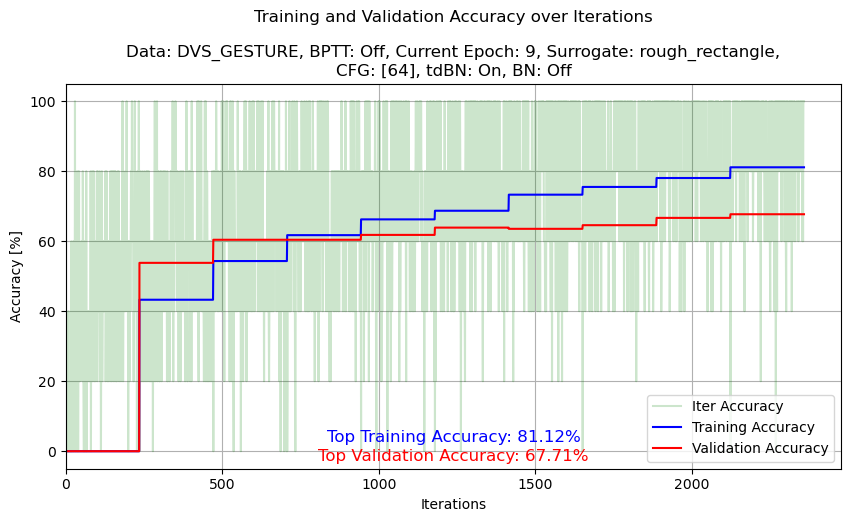

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

def pad_array_to_match_length(array1, array2):
    if len(array1) > len(array2):
        padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
        return array1, padded_array2
    elif len(array2) > len(array1):
        padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
        return padded_array1, array2
    else:
        return array1, array2
def load_hyperparameters(filename='hyperparameters.json'):
    with open(filename, 'r') as f:
        return json.load(f)
    




current_time = '20240628_110116'
base_name = f'{current_time}'
iter_acc_file_name = f'result_save/{base_name}_iter_acc_array.npy'
val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

### if you want to just see most recent train and val acc###########################
iter_acc_file_name = 'result_save/iter_acc_array.npy'
tr_acc_file_name = 'result_save/tr_acc_array.npy'
val_acc_file_name = 'result_save/val_acc_now_array.npy'
hyperparameters_file_name = 'result_save/hyperparameters.json'

loaded_iter_acc_array = np.load(iter_acc_file_name)*100
loaded_tr_acc_array = np.load(tr_acc_file_name)*100
loaded_val_acc_array = np.load(val_acc_file_name)*100
hyperparameters = load_hyperparameters(hyperparameters_file_name)

loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

top_iter_acc = np.max(loaded_iter_acc_array)
top_tr_acc = np.max(loaded_tr_acc_array)
top_val_acc = np.max(loaded_val_acc_array)

which_data = hyperparameters['which_data']
BPTT_on = hyperparameters['BPTT_on']
current_epoch = hyperparameters['current epoch']
surrogate = hyperparameters['surrogate']
cfg = hyperparameters['cfg']
tdBN_on = hyperparameters['tdBN_on']
BN_on = hyperparameters['BN_on']


iterations = np.arange(len(loaded_iter_acc_array))

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # 텍스트 추가
# plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# 텍스트 추가
plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

plt.xlabel('Iterations')
plt.ylabel('Accuracy [%]')

# 그래프 제목에 하이퍼파라미터 정보 추가
title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

plt.title(title)

plt.legend(loc='lower right')
plt.xlim(0)  # x축을 0부터 시작
plt.grid(True)
plt.show()

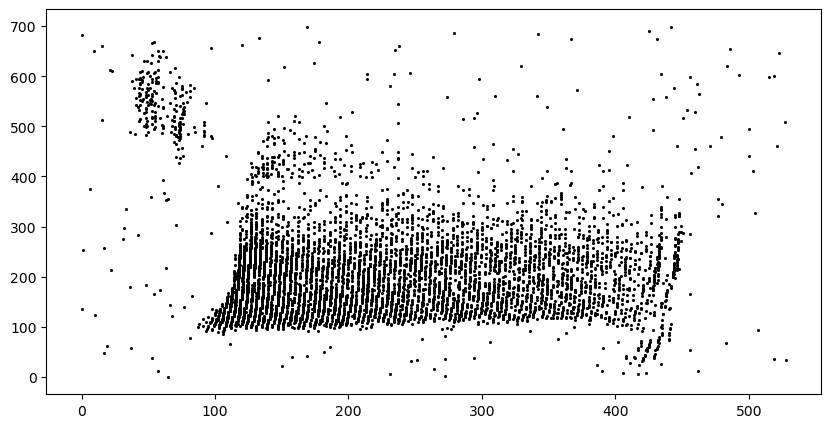

In [ ]:
import snntorch as snn
from snntorch.spikevision import spikedata
from torch.utils.data import DataLoader


# root, train=True, transform=None, target_transform=None, download_and_create=True, num_steps=1000, ds=1, dt=1000)
train_ds = spikedata.SHD("/data2/Heidelberg", train=True)
test_ds = spikedata.SHD("/data2/Heidelberg", train=False)

# create dataloaders
train_dl = DataLoader(train_ds, shuffle=True, batch_size=64) # 8156x2x1000x700
test_dl = DataLoader(test_ds, shuffle=False, batch_size=64) # 2264x2x1000x700

import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

# choose a random sample
n = 6295

# initialize figure and axes
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)

# use spikeplot to generate a raster
splt.raster(train_dl.dataset[n][0], ax, s=1.5, c="black")